In [2]:
from matplotlib import pyplot as plt
import time
import arviz as az
import numpy as np
import pymc as pm

rng = np.random.default_rng(1690)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Sampling: [s]


-536.2931752204895 seconds to run


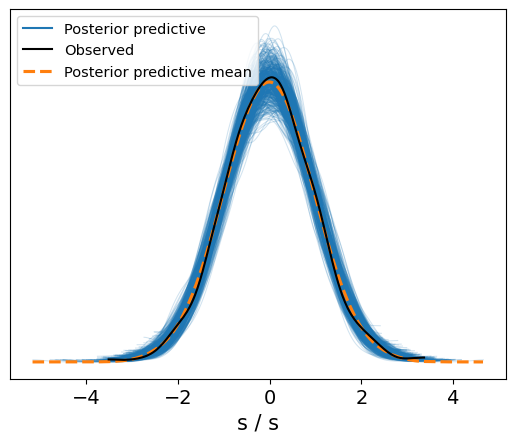

In [4]:
start = time.time()
data = np.random.normal(loc=0, scale=1, size=1000)
def normal_sim(rng, a, b, size=1000):
    return rng.normal(a, b, size=size)
with pm.Model() as example:
    a = pm.Normal("a", mu=0, sigma=5)
    b = pm.HalfNormal("b", sigma=1)
    s = pm.Simulator("s", normal_sim, params=(a, b), sum_stat="sort", epsilon=1, observed=data)

    idata = pm.sample_smc(progressbar= False)
    idata.extend(pm.sample_posterior_predictive(idata))
az.plot_ppc(idata, num_pp_samples=500)
az.summary(idata, kind="stats")
print(f"{start - time.time()} seconds to run")

In [3]:
from scipy.integrate import odeint

X0 = [95,5,0.0]
# size of data
size = 200
# time lapse
time = 20
t = np.linspace(0.0, time, size)
b = 3
g = 1

# SIR
def dX_dt(X, t, b, g):
    """Return the growth rate of fox and rabbit populations."""

    return np.array([-b*X[0]*X[1]/sum(X),b*X[0]*X[1]/sum(X) - g*X[1], g*X[1]])


# simulator function
def competition_model(rng, b, g, size=None):
    return odeint(dX_dt, y0=X0, t=t, rtol=0.01, args=(b,g))

In [4]:
out = odeint(dX_dt, y0=X0, t=t, rtol=0.01, args=(b,g))

In [5]:
print(out)

[[9.50000000e+01 5.00000000e+00 0.00000000e+00]
 [9.34402424e+01 6.00792773e+00 5.51829836e-01]
 [9.16045899e+01 7.18221492e+00 1.21319522e+00]
 [8.94637900e+01 8.53475622e+00 2.00145382e+00]
 [8.69933046e+01 1.00718032e+01 2.93489223e+00]
 [8.41766206e+01 1.17913475e+01 4.03203183e+00]
 [8.10089248e+01 1.36804112e+01 5.31066399e+00]
 [7.75003892e+01 1.57130037e+01 6.78660712e+00]
 [7.36787886e+01 1.78487872e+01 8.47242415e+00]
 [6.96163912e+01 2.00088875e+01 1.03747213e+01]
 [6.53466188e+01 2.21594830e+01 1.24938982e+01]
 [6.09643719e+01 2.42155203e+01 1.48201078e+01]
 [5.65299629e+01 2.61232192e+01 1.73468179e+01]
 [5.21435552e+01 2.78083503e+01 2.00480945e+01]
 [4.78649835e+01 2.92270846e+01 2.29079319e+01]
 [4.37810161e+01 3.03386307e+01 2.58803532e+01]
 [3.99387408e+01 3.11208517e+01 2.89404075e+01]
 [3.63444749e+01 3.15768796e+01 3.20786455e+01]
 [3.30395430e+01 3.17272021e+01 3.52332549e+01]
 [3.00314359e+01 3.15755333e+01 3.83930308e+01]
 [2.73131960e+01 3.11502509e+01 4.153655

In [6]:
# function for generating noisy data to be used as observed data.
def add_noise(a, b):
    noise = np.random.normal(size=(size, 3))
    simulated = competition_model(None, a, b) + noise
    return simulated

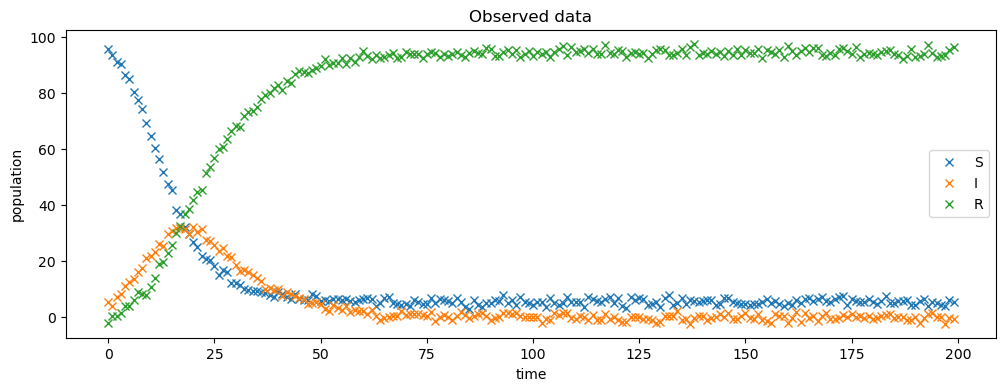

In [7]:
# plotting observed data.
observed = add_noise(b,g)
_, ax = plt.subplots(figsize=(12, 4))
ax.plot(observed[:, 0], "x", label="S")
ax.plot(observed[:, 1], "x", label="I")
ax.plot(observed[:, 2], "x", label="R")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.set_title("Observed data")
ax.legend();

In [8]:
with pm.Model() as model_lv:
    b = pm.HalfNormal("b", 1.0)
    g = pm.HalfNormal("g", 1.0)

    sim = pm.Simulator("sim", competition_model, params=(b, g), epsilon=10, observed=observed)

    idata_lv = pm.sample_smc(progressbar=False)

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


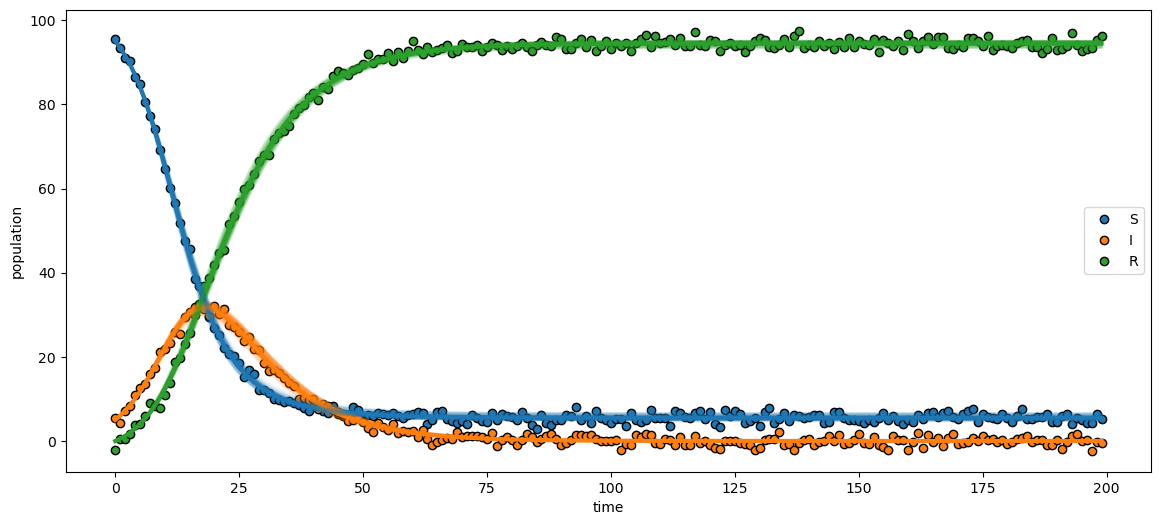

In [11]:
# plot results
_, ax = plt.subplots(figsize=(14, 6))
posterior = idata_lv.posterior.stack(samples=("draw", "chain"))
ax.plot(observed[:, 0], "o", label="S", c="C0", mec="k")
ax.plot(observed[:, 1], "o", label="I", c="C1", mec="k")
ax.plot(observed[:, 2], "o", label="R", c="C2", mec="k")
ax.plot(competition_model(None, posterior["b"].mean(), posterior["g"].mean()), linewidth=3)
for i in np.random.randint(0, size, 75):
    sim = competition_model(None, posterior["b"][i], posterior["g"][i])
    ax.plot(sim[:, 0], alpha=0.1, c="C0")
    ax.plot(sim[:, 1], alpha=0.1, c="C1")
    ax.plot(sim[:, 2], alpha=0.1, c="C2")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.legend();

array([<Axes: title={'center': 'b'}>, <Axes: title={'center': 'g'}>],
      dtype=object)

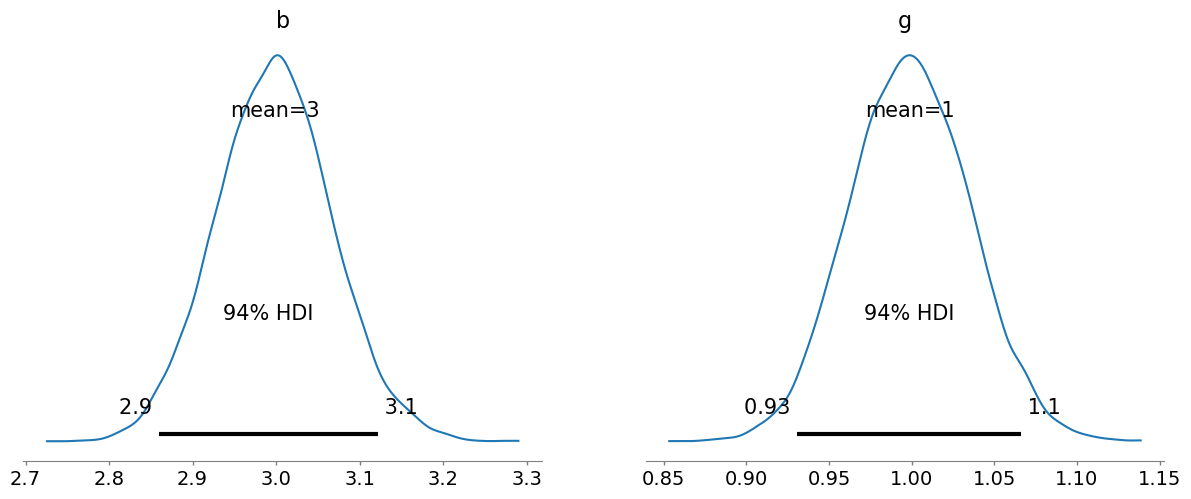

In [13]:
az.plot_posterior(idata_lv)